### Note:
* For simplicity, I will first focus on the sampled dataframe where preference is given to papers with AI in the subject name. 
* Through function design, I will try to ensure that similar analysis can be run for any sampled cut of the metadata

In [75]:
# Importing libraries
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [57]:
# Load the combined metadata CSV file
current_dir = os.getcwd()
combined_file = os.path.join(current_dir, '..', 'data', 'metadata_sampled_ai_and_random.csv') # change this name to get a different cut
df = pd.read_csv(combined_file)

# Ensure consistent column names
df.columns = [col.strip() for col in df.columns]

# Get df info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dc.contributor.advisor      115 non-null    object 
 1   dc.contributor.author       400 non-null    object 
 2   dc.date.accessioned         400 non-null    object 
 3   dc.date.available           400 non-null    object 
 4   dc.date.issued              400 non-null    object 
 5   dc.identifier.uri           400 non-null    object 
 6   dc.relation.ispartofseries  377 non-null    object 
 7   dc.title                    400 non-null    object 
 8   dc.description.abstract     388 non-null    object 
 9   dc.identifier.other         282 non-null    object 
 10  dc.format.extent            362 non-null    object 
 11  dc.format.mimetype          262 non-null    object 
 12  dc.language.iso             268 non-null    object 
 13  dc.subject                  297 non

In [58]:
# First, let's define a function to create a dataframe with paper IDs and author names
def create_authors_dataframe(df):
    # Extract research paper ID and authors
    authors_df = df[['research_paper_id', 'year','dc.contributor.author']].dropna()
    authors_df = authors_df.assign(author=authors_df['dc.contributor.author'].str.split(';')).explode('author')
    authors_df['author'] = authors_df['author'].str.strip()

    # Assign unique IDs to each author
    authors_df['author_id'] = authors_df['author'].factorize()[0] + 1
    return authors_df[['research_paper_id', 'year', 'author_id', 'author']]

In [59]:
# Calling the function to create the authors dataframe
authors_df = create_authors_dataframe(df)
authors_df.to_csv(os.path.join(current_dir, '..', 'data', 'authors.csv'), index=False)
print(f"Authors DataFrame created and saved. Top 5 rows are {authors_df.head(5)}.")

Authors DataFrame created and saved. Top 5 rows are    research_paper_id  year  author_id                        author
0                 13  2000          1  Papageorgiou, Constantine P.
1                 15  2000          2           Evgeniou, Theodoros
1                 15  2000          3          Pontil, Massimiliano
2                 55  2001          4          Sezgin, Tevfik Metin
3                 56  2001          5                Banks, Jessica.


In [60]:
# Importing the census data
census_file = os.path.join(current_dir, '..', 'data', 'census_names', 'Names_2010Census.csv')
census_df = pd.read_csv(census_file)

# Get df info
print(census_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162254 entries, 0 to 162253
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   name          162253 non-null  object 
 1   rank          162254 non-null  int64  
 2   count         162254 non-null  int64  
 3   prop100k      162254 non-null  float64
 4   cum_prop100k  162254 non-null  float64
 5   pctwhite      162254 non-null  object 
 6   pctblack      162254 non-null  object 
 7   pctapi        162254 non-null  object 
 8   pctaian       162254 non-null  object 
 9   pct2prace     162254 non-null  object 
 10  pcthispanic   162254 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 13.6+ MB
None


In [61]:
# Keep relevant columns from census dataframe
# Filter relevant columns
keep_columns = ['name', 'pctwhite', 'pctblack', 'pctapi', 'pcthispanic', 'pctaian', 'pct2prace']
census_df = census_df[keep_columns]

# Filter out rows where a percentage has value (S) or name is null
census_df = census_df[census_df['name'].notnull()]

# Examine dataframe
census_df.head(5)

,name,pctwhite,pctblack,pctapi,pcthispanic,pctaian,pct2prace
0,SMITH,70.9,23.11,0.5,2.4,0.89,2.19
1,JOHNSON,58.97,34.63,0.54,2.36,0.94,2.56
2,WILLIAMS,45.75,47.68,0.46,2.49,0.82,2.81
3,BROWN,57.95,35.6,0.51,2.52,0.87,2.55
4,JONES,55.19,38.48,0.44,2.29,1,2.61


In [62]:
# Map ethnicity based on max(percentage) for each name

def get_ethnicity(row):
    ethnicities = ['pctwhite', 'pctblack', 'pctapi', 'pcthispanic', 'pctaian', 'pct2prace']
    return max(ethnicities, key=lambda x: row[x])

# Apply the function to the census dataframe
census_df['ethnicity'] = census_df.apply(get_ethnicity, axis=1)

# Encode the target labels
ethnicity_mapping = {
    'pctwhite': 'White', 
    'pctblack': 'Black', 
    'pctapi': 'API', 
    'pcthispanic': 'Hispanic', 
    'pctaian': 'AIAN', 
    'pct2prace': 'Two or More Races'
}

# Map the encoding
census_df['ethnicity'] = census_df['ethnicity'].map(ethnicity_mapping)

# Examine the dataframe and export as csv
census_df.head(5)
census_df.to_csv(os.path.join(current_dir, '..', 'data', 'census_names', 'Names_2010Census_encoded.csv'), index=False)

In [63]:
# Find the closest match in the author names dataframe for each name in the census dataframe
# Split author names into first and last names
authors_df['last_name'] = authors_df['author'].apply(lambda x: x.split(',')[0])
authors_df.head(5)

,research_paper_id,year,author_id,author,last_name
0,13,2000,1,"Papageorgiou, Constantine P.",Papageorgiou
1,15,2000,2,"Evgeniou, Theodoros",Evgeniou
1,15,2000,3,"Pontil, Massimiliano",Pontil
2,55,2001,4,"Sezgin, Tevfik Metin",Sezgin
3,56,2001,5,"Banks, Jessica",Banks


In [64]:
# Combine census names and author names to create a common vocabulary
combined_names = pd.concat([census_df['name'], authors_df['last_name']])

# Create TF-IDF vectors for the combined names
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
combined_name_vectors = vectorizer.fit_transform(combined_names)

# Split the combined vectors back into census and author vectors
census_name_vectors = combined_name_vectors[:len(census_df)]
author_name_vectors = combined_name_vectors[len(census_df):]

In [65]:
# Function to find the closest surname using cosine similarity
def find_closest_surname_cosine(author_vector, census_name_vectors, census_df):
    similarities = cosine_similarity(author_vector, census_name_vectors)
    most_similar_index = np.argmax(similarities)
    return census_df.iloc[most_similar_index]['name']

In [66]:
# Apply cosine similarity to find the closest surnames from census
authors_df['similar_surname'] = [find_closest_surname_cosine(author_name_vectors[i], census_name_vectors, census_df) for i in range(len(authors_df))]

# Examine the dataframe
authors_df.head(10)

,research_paper_id,year,author_id,author,last_name,similar_surname
0,13,2000,1,"Papageorgiou, Constantine P.",Papageorgiou,PAPAGEORGIOU
1,15,2000,2,"Evgeniou, Theodoros",Evgeniou,NIOUS
1,15,2000,3,"Pontil, Massimiliano",Pontil,PONTILLO
2,55,2001,4,"Sezgin, Tevfik Metin",Sezgin,SEZER
3,56,2001,5,"Banks, Jessica",Banks,BANKS
4,57,2001,6,"Ucko, Aaron Mark",Ucko,BUCKO
5,60,2001,7,"Ho, Purdy",Ho,HO
6,61,2001,8,"Nagpal, Radhika",Nagpal,NAGPAL
7,63,2001,9,"Alvira, Mariano",Alvira,ALVIRA
7,63,2001,10,"Paris, Jim",Paris,PARIS


In [67]:
# Directly lookup the ethnicity for the closest surname
authors_df['predicted_ethnicity'] = authors_df['similar_surname'].map(census_df.set_index('name')['ethnicity'])

# Examine the dataframe
authors_df.head(10)

,research_paper_id,year,author_id,author,last_name,similar_surname,predicted_ethnicity
0,13,2000,1,"Papageorgiou, Constantine P.",Papageorgiou,PAPAGEORGIOU,White
1,15,2000,2,"Evgeniou, Theodoros",Evgeniou,NIOUS,Black
1,15,2000,3,"Pontil, Massimiliano",Pontil,PONTILLO,Hispanic
2,55,2001,4,"Sezgin, Tevfik Metin",Sezgin,SEZER,White
3,56,2001,5,"Banks, Jessica",Banks,BANKS,Black
4,57,2001,6,"Ucko, Aaron Mark",Ucko,BUCKO,White
5,60,2001,7,"Ho, Purdy",Ho,HO,API
6,61,2001,8,"Nagpal, Radhika",Nagpal,NAGPAL,API
7,63,2001,9,"Alvira, Mariano",Alvira,ALVIRA,Hispanic
7,63,2001,10,"Paris, Jim",Paris,PARIS,Hispanic


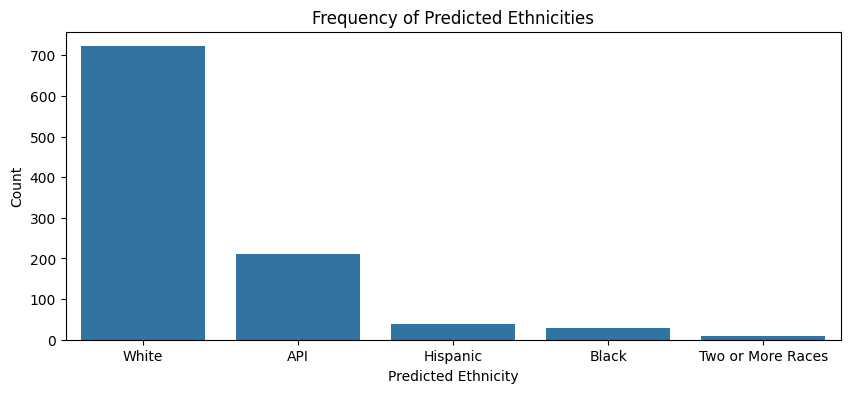

In [79]:
# Plot frequency of predicted ethnicities
plt.figure(figsize=(10, 4))
sns.countplot(data=authors_df, x='predicted_ethnicity', order=authors_df['predicted_ethnicity'].value_counts().index)
plt.title('Frequency of Predicted Ethnicities')
plt.xlabel('Predicted Ethnicity')
plt.ylabel('Count')
plt.show()

In [74]:
# Show the top 5 most occurring last names for each predicted ethnicity
top_last_names = authors_df.groupby('predicted_ethnicity')['last_name'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index()
top_last_names.columns = ['predicted_ethnicity', 'last_name', 'count']

# Display the result
print(top_last_names)

   predicted_ethnicity    last_name  count
0                  API        Sinha     13
1                  API         Chen     11
2                  API       Katabi     10
3                  API  Amarasinghe      9
4                  API    Mukherjee      8
5                Black       Durand      5
6                Black     Williams      3
7                Black       Badoiu      2
8                Black          Che      2
9                Black      Cowling      2
10            Hispanic     Torralba     15
11            Hispanic        Paris      2
12            Hispanic  Perez-Breva      2
13            Hispanic      Sanchez      2
14            Hispanic     Alvarado      1
15   Two or More Races      Taycher      3
16   Two or More Races          Abe      1
17   Two or More Races         Adib      1
18   Two or More Races          Ali      1
19   Two or More Races     Ishikawa      1
20               White       Poggio     29
21               White       Rinard     21
22         